# VC Dimension, Halfspaces, and the Polynomial Kernel

The perceptron hypothesis class is often called the hypothesis class of "half spaces" because it divides the space $R^d$ in half with a hyperplane.
In this assignment, you will create various synthetic datasets, and explore how changing the hyperparameters of the halfspace hypothesis class with the polynomial kernel affects the statistical performance.
The advantage of using synthetic data is that you can control various aspects of the data generation process to see how different sources of error result in different types of output.

The main purpose of this assignment is to help give you intuition for all of the terms and formulas we've been defining in lecture.

In [1]:
'''
This cell contains imports and global configurations.
You shouldn't have to modify anything in this cell.
'''

# import standard python libraries libraries
import math
import numpy as np
np.random.seed(0)
import random
random.seed(0)
import time

# disable warnings
from warnings import filterwarnings
filterwarnings('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"

# import data mining libraries
import sklearn.linear_model

# import and configure plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 1
#plt.rcParams['figure.figsize'] = [9, 6]
#plt.rcParams['figure.dpi'] = 150

# configurations for my code
default_num_trials = 25
max_d = 2**14

## Part 1: Exploring the VC Dimension of the polynomial kernel

In [4]:
def polynomial_kernel_embedding(x, p):
    '''
    Embeds the vector x into a higher dimensional space using the polynomial kernel of degree p.
    The output dimension is equal to the VC-dimension of Theta(min{p**d,d**p}), where d is the dimension of x.
    This is not an efficient implementation; it is designed for clarity.

    >>> polynomial_kernel_embedding(np.array([2]),1)
    array([2])
    >>> polynomial_kernel_embedding(np.array([2]),2)
    array([2, 4])
    >>> polynomial_kernel_embedding(np.array([2]),3)
    array([2, 4, 8])

    >>> polynomial_kernel_embedding(np.array([2,3]),1)
    array([2, 3])
    >>> polynomial_kernel_embedding(np.array([2,3]),2)
    array([2, 3, 4, 6, 9])
    >>> polynomial_kernel_embedding(np.array([2,3]),3)
    array([ 2,  3,  4,  6,  9,  8, 12, 18, 27])

    >>> polynomial_kernel_embedding(np.array(range(2)),10).shape
    (65,)
    >>> polynomial_kernel_embedding(np.array(range(3)),10).shape
    (285,)
    >>> polynomial_kernel_embedding(np.array(range(4)),10).shape
    (1000,)
    '''
    assert type(x) is np.ndarray
    assert len(x.shape) == 1
    assert type(p) is int
    assert p > 0

    d = x.shape[0]
    terms_per_degree = [ [ [i] for i in range(d) ] ]
    for i in range(1,p):
        deg_i_terms = []
        deg_i_minus1_terms = terms_per_degree[-1]
        for k in range(len(deg_i_minus1_terms)):
            for j in range(deg_i_minus1_terms[k][-1],d):
                deg_i_terms.append(deg_i_minus1_terms[k]+[j])
        terms_per_degree.append(deg_i_terms)

    terms = [ inner for outer in terms_per_degree for inner in outer ]

    values = []
    for term in terms:
        value = 1
        for i in term:
            value *= x[i]
        values.append(value)
    return np.array(values)

    embeddings = [x]
    for i in range(1,p):
        deg_i_terms = []
        deg_i_minus1_terms = embeddings[-1]
        for j in range(x.shape[0]):
            for k in range(deg_i_minus1_terms.shape[0]):
                deg_i_terms.append(x[j]*deg_i_minus1_terms[k])
        embeddings.append(np.array(deg_i_terms))
    return np.concatenate(embeddings)

import doctest
doctest.testmod()

TestResults(failed=0, attempted=9)

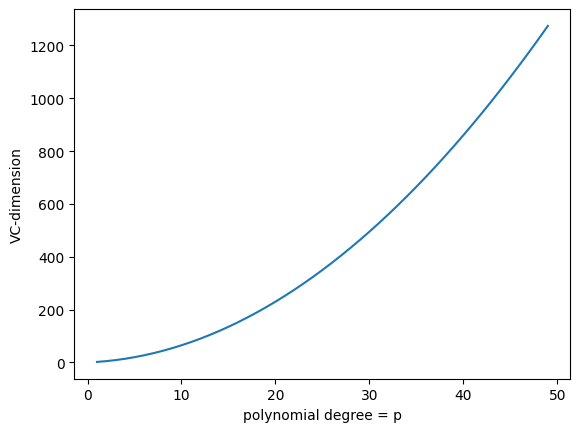

In [5]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as a function of the degree p with a fixed dimension d
'''
ps = range(1,50)
d = 2
vcdims = [ polynomial_kernel_embedding(np.ones([d]),p).shape for p in ps ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('polynomial degree = p')
plt.plot(ps,vcdims)
plt.show()

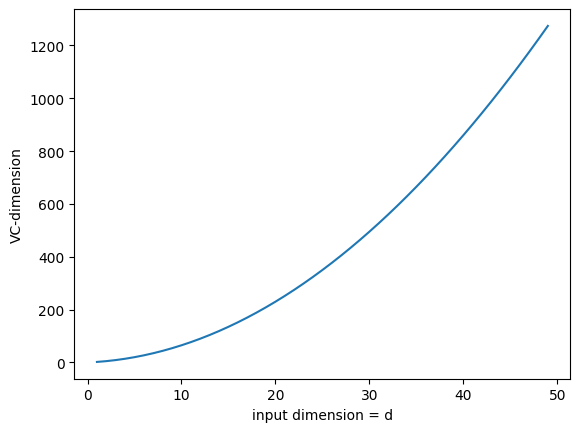

In [6]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as a function of the dimension d with a fixed p
'''
ds = range(1,50)
p = 2
vcdims = [ polynomial_kernel_embedding(np.ones([d]),p).shape for d in ds ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('input dimension = d')
plt.plot(ps,vcdims)
plt.show()

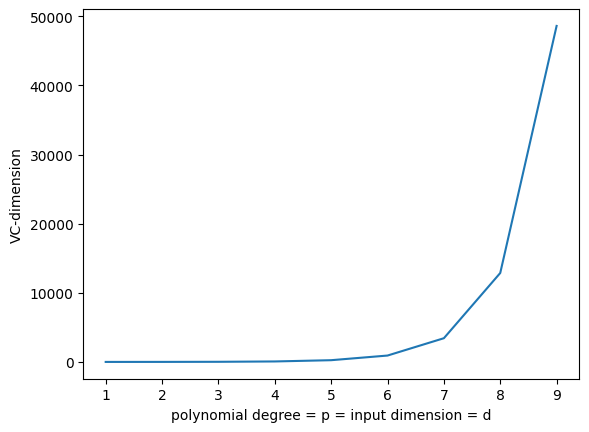

In [7]:
'''
This cell plots the VC-dimension of a halfspace with the polynomial kernel
as the dimension and degree both increase
'''
dps = range(1,10)
vcdims = [ polynomial_kernel_embedding(np.ones([dp]),dp).shape for dp in dps ]

fig, ax = plt.subplots()
plt.ylabel('VC-dimension')
plt.xlabel('polynomial degree = p = input dimension = d')
plt.plot(dps,vcdims)
plt.show()

### Question 1.1
*The plots above visualize the VC-dimension of halfspaces with the polynomical kernel.
In particular, they show regimes where the VC-dimension grows polynomially and regimes where it grows exponentially.*

*What is the formula for the VC-dimension of halfspaces with the polynomial kernel?*

The formula for the VC-dimension of the perceptron hypothesis class is equal to the new dimension under the mapping, which is $\tilde{d} = {Q + d \choose Q} = \Theta(d^Q)$.

### Question 1.2
*In most practical problems, the dimension $d$ of the input dataspace $\mathcal X$ is large ( think $d > 10^{6}$).
Large degree polynomial kernels ($p>3$) are not typically used in this situation.
Explain the downsides of using a large degree polynomial kernel in terms of sample complexity using VC theory.*

According to the answer from question 1.1, the VC-dimension of halfspaces with a polynomial kernel grows exponentially as the size of the kernel increases. This means that by the VC generalization bound, $E_{out} \leq E_{in} + O(\sqrt{\frac{d_{VC}\log(N) - \log(\delta)}{N}})$, the generalization error will be large since $d_{VC}$ is large for large $Q$.

## Part 2: generating synthetic data with different properties

In [9]:
'''
This cell contains a number of functions for generating and visualizing datasets.
'''

def generate_dataset(m, d, f, sigma, seed=0):
    '''
    Returns a dataset with m data points of dimension d generated by:

        X ~ Uniform(-1, 1)
        Y = f(X) + epsilon, where epsilon ~ Normal(0,sigma)

    When sigma=0, there is no randomness in Y, and so the bayes error will be 0
    When sigma>0, there is randomness in Y, and so the bayes error > 0
    '''
    # set numpy's seed for reproducable results
    random.seed(seed)
    np.random.seed(seed)

    # ensure reasonable input parameters
    assert type(m) is int
    assert m>0

    # a helper function for generating labels
    def sign(a):
        if a>0:
            return 1
        else:
            return -1

    # generate the features
    X = np.random.uniform(low=-1.0,high=1.0,size=[m,d])

    # generate the labels
    Ys = []
    for i in range(m):
        epsilon = np.random.randn()*sigma
        yi = sign(f(X[i]) + epsilon)
        Ys.append(yi)
    Y = np.array(Ys)

    # return the dataset
    return (X,Y)


def f_polynomial(p, seed=0):
    '''
    Implements a polynomial embedding of degree $p$ to perform the data labeling.
    If the halfspace hypothesis class with the polynomial kernel of degree > p is used for learning,
    then the hypothesis class will be realizable.
    The input dimension $d$ must match the dimension of the dataspace $\mathcal X$
    '''
    phi = lambda x: polynomial_kernel_embedding(x, p)
    embedding_dim = phi(np.ones([d])).shape[0]
    np.random.seed(seed)
    #w = (np.array(range(embedding_dim))/embedding_dim)**0.01
    #w = np.ones([embedding_dim])/embedding_dim
    w = np.random.randn(max_d)/math.sqrt(embedding_dim)
    def f(x):
        phi_x = phi(x)
        w2 = w[:phi_x.shape[0]]
        return phi_x.transpose() @ w2
    return f


def f_checkers():
    '''
    This is another embedding function that creates a "checkers" pattern in the data.
    This embedding is not realizable for halfspaces with the polynomial kernel.
    '''
    p = 4
    def f(x):
        return math.sin(x[0]*p)*math.sin(x[1]*p)
    return f


def f_circles():
    '''
    This is another embedding function that creates a pattern of concentric circles in the data.
    This embedding is not realizable for halfspaces with the polynomial kernel.
    '''
    p = 4
    def f(x):
        return math.cos((x[0]*x[0]+x[1]*x[1])*p)
    return f


def plot_dataset(S):
    '''
    Plots the first two dimensions of the input dataset.
    '''
    X,Y = S
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],c=Y)
    #ax.scatter(X_pos[:,0], X_pos[:,1])
    #ax.scatter(X_neg[:,0], X_neg[:,1])
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)
    plt.tight_layout()
    plt.show()

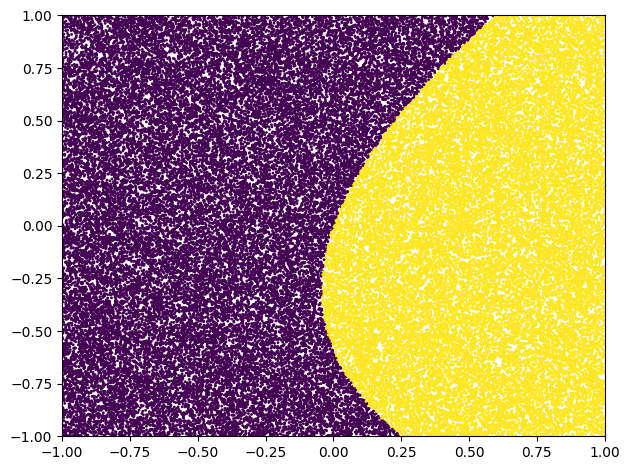

In [36]:
'''
This cell plots a dataset that has no randomness in the generation of class labels (sigma=0).
Using our notation from the textbook, this means that for each i, y_i = f(x_i).
When p=1 in the f_polynomial function, the data has a linear decision boundary.
'''

# these "hyperparameters" control the properties of the dataset
d = 2
sigma = 0
f = f_polynomial(p=2,seed=7)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)

### Question 2.1

*Regenerate the dataset above several times with degree $1 \le p \le 10$ to explore what decision boundaries for higher degree polynomials look like.
You should also change the `seed` value to generate different datasets with the same degree.*

*Write a 1-2 sentence summary of your findings.*

For $p = 1$, the decision boundary is a line; for $p = 2$, the bound typically appears elliptical; as $p$ increases, the boundary becomes more complex, and there is more variation for different seeds.

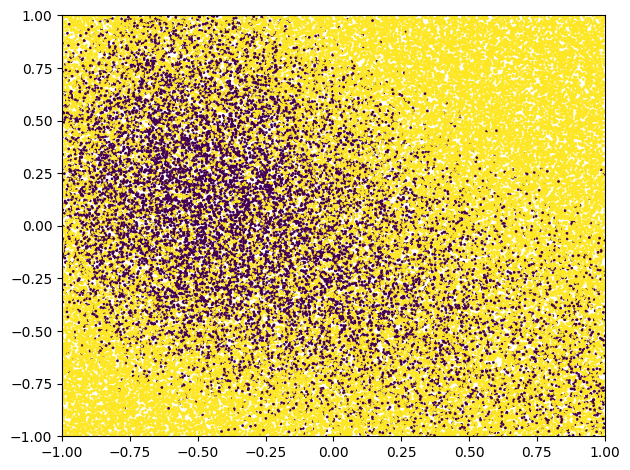

In [10]:
'''
This cell plots a dataset with randomness (sigma>0).
The sigma variable controls the amount of randomness applied to the model's label.
'''

# these "hyperparameters" control the properties of the dataset
d = 2
sigma = 0.3
f = f_polynomial(4)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)

### Question 2.2

*Experiment with different combinations of sigma (and different p values) to see how the level of randomness effects the data.*

*Write a 1-2 sentence summary of your findings.*

For $\sigma = 0$, there is no overlap between the regions. As $\sigma$ increases, the boundary between the yellow and purple data points becomes hazier.

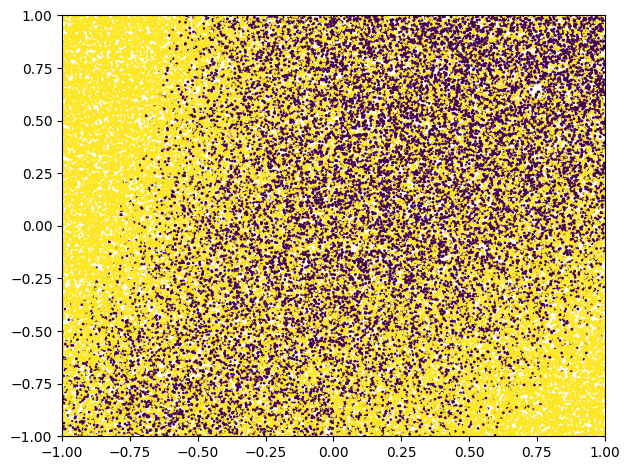

In [11]:
'''
This cell plots a dataset in the PAC model in higher dimensions.
Notice that even though there is no randomness in the labels,
there appears to be randomness when we only visualize the data in 2 dimensions.
'''

# these "hyperparameters" control the properties of the dataset
d = 3
sigma = 0
f = f_polynomial(d,2)

# generate and plot dataset
S = generate_dataset(m=2**16,d=d,f=f,sigma=sigma)
plot_dataset(S)

### Question 2.3

*Experiment with different values of `d` in the dataset plotted above.
Also experiment with different values of `p` and `sigma`.
Notice that in high dimensions it is very difficult to tell if the data is linearly separable, or if the data contains any randomness.
Write 1-2 sentences explaining why this is the case.*

This is because the higher dimensional data is being projected and visualized in 2 dimensions, which makes it harder to distinguish between points even if the data is linearly separable.

## Part 3: plotting the error as a function of the sample size $m$

NOTE: The textbook uses the variable $N$ to measure the total number of data points, but this notebook uses the variable $m$ to denote the number of data points.

In [14]:
def calculate_err_vs_m(d, sigma, f, p, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of the number of sample training points.
    '''

    max_m_exp = 16
    m_buffer = 3

    # S_test is our test set used for measuring the model's performance;
    # It has a very large size to ensure that the empirical risk on S_test is very close to the true risk
    print('generating dataset... ',end='')
    S_test = generate_dataset(m=2**(max_m_exp+m_buffer),d=d,f=f,sigma=sigma)
    print('done')
    plot_dataset(S_test)

    # these lists store the computer training and test errors
    test_errs = []
    train_errs = []

    # This is the list of all sample sizes we will train models on and generate train/test errors;
    # by adjusting the range(), you can adjust the x-axis in the plots below.
    ms = [ 2**i for i in range(0,max_m_exp) ]

    for m in ms:
    #for p in [1,2,3,4,5,6,7]:

        # In order to "smooth" the plots, we will repeat each experiment multiple times
        # as deterimed by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []

        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base,seed_base+num_trials):

            # generate a training set of size m
            # from the same distribution as our test set;
            # notice that we must explicitly set a unique seed for each trial so that
            # each iteration is actually running on a different training set
            S_train = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed)

            try:
                # train a linear model;
                # notice that all of these models use the same hypothesis set of half spaces;
                # they only difference is that a different algorithm is used to select the hypothesis from the hypothesis class;
                # VC theory doesn't care about the training algorithm used to select the hypothesis from the class,
                # and so provides the same generalization bounds for all of these algorithms;
                # in practice, they all perform essentially the same statistically,
                # but they have different runtime characteristics in different situations
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                #h_S = sklearn.linear_model.LogisticRegression(solver='liblinear',C=1e10)
                #h_S = sklearn.linear_model.Perceptron()
                h_S = sklearn.linear_model.SGDClassifier(penalty=None)
                #h_S = sklearn.linear_model.PassiveAggressiveClassifier()
                #h_S = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                #h_S = sklearn.svm.LinearSVC()
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X,Y)

                # calculate the test accuracy
                X, Y = S_test
                X = X[:min(2048,m_buffer*m)]
                Y = Y[:min(2048,m_buffer*m)]
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                test_acc = h_S.score(X, Y)

            # ValueError raised when there's not enough data to perform classification;
            # in this case, we get perfect training accuracy, but perfectly wrong test accuracy
            except ValueError:
                train_acc = 1
                test_acc = 0

            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()

        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)

        # print a debugging statement for each iteration
        print('m=%8d,  train_acc=%0.4f,  test_acc=%0.4f,  time_diff=%dsec'%(
            m,
            train_acc,
            test_acc,
            time_end-time_start
        ))

        # convert the accuracies into errors and store them
        train_errs.append(1-train_acc)
        test_errs.append(1-test_acc)

    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.set_xscale('log',base=2)
    #ax1.set_yscale('log')
    ax1.set_ylim([0.0,1.0])
    ax1.set(
        xlabel='number of samples = m',
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ms,train_errs)

    ax2.set_xscale('log',base=2)
    #ax2.set_yscale('log')
    ax2.set_ylim([0.0,1.0])
    ax2.set(
        xlabel='number of samples = m',
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ms,test_errs)

    ax3.set_xscale('log',base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='number of samples = m',
        ylabel='generalization error = |E_in(g) - E_out(g)|',

    )
    ax3.plot(ms,np.abs(np.array(test_errs)-np.array(train_errs)))

    plt.tight_layout()
    plt.show()


generating dataset... done


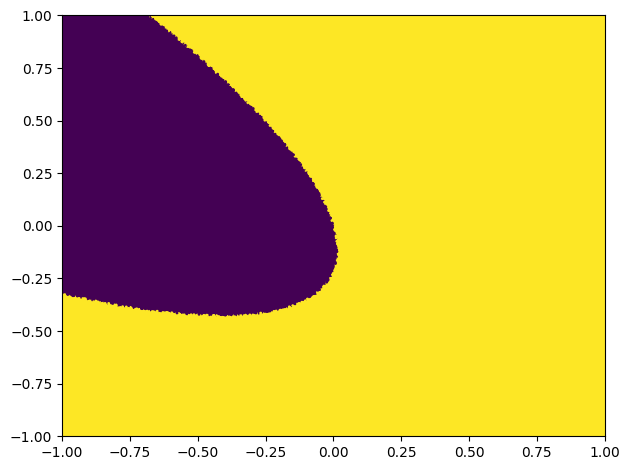

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2400,  time_diff=0sec
m=       4,  train_acc=0.9900,  test_acc=0.4800,  time_diff=0sec
m=       8,  train_acc=0.9250,  test_acc=0.7083,  time_diff=0sec
m=      16,  train_acc=0.8775,  test_acc=0.8058,  time_diff=0sec
m=      32,  train_acc=0.8538,  test_acc=0.8325,  time_diff=0sec
m=      64,  train_acc=0.8313,  test_acc=0.8325,  time_diff=0sec
m=     128,  train_acc=0.8237,  test_acc=0.8068,  time_diff=0sec
m=     256,  train_acc=0.8144,  test_acc=0.8040,  time_diff=0sec
m=     512,  train_acc=0.8210,  test_acc=0.8224,  time_diff=0sec
m=    1024,  train_acc=0.8335,  test_acc=0.8272,  time_diff=0sec
m=    2048,  train_acc=0.8340,  test_acc=0.8298,  time_diff=0sec
m=    4096,  train_acc=0.8348,  test_acc=0.8300,  time_diff=1sec
m=    8192,  train_acc=0.8357,  test_acc=0.8315,  time_diff=3sec
m=   16384,  train_acc=0.8374,  test_acc=0.8327,  time_diff=8sec
m=   32768,  train_acc=0.

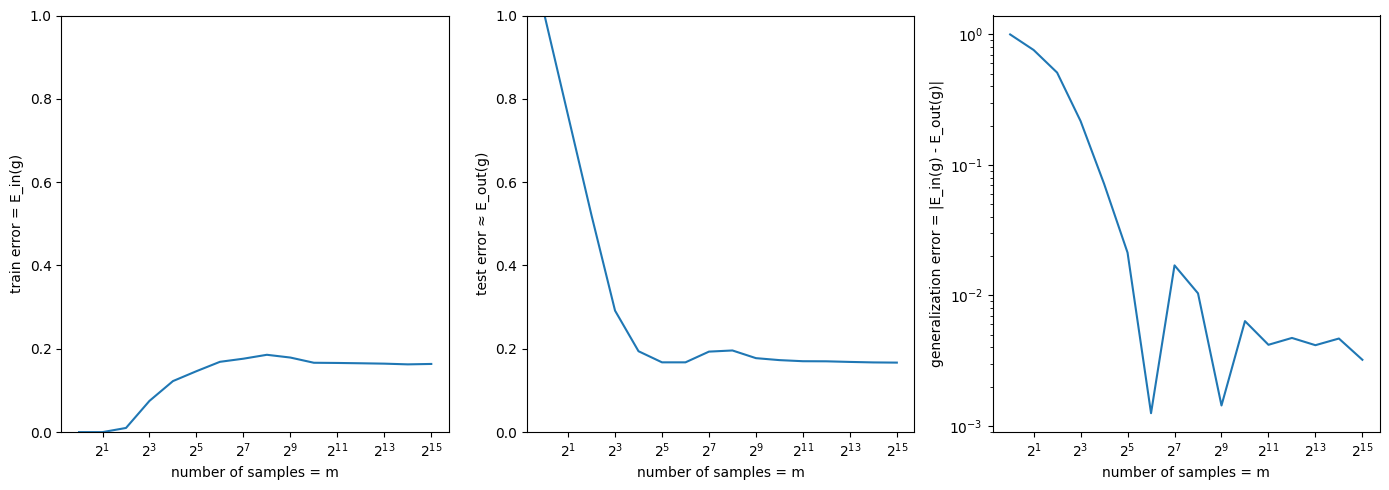

In [15]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_polynomial(p=2),
    p=1,
)

generating dataset... done


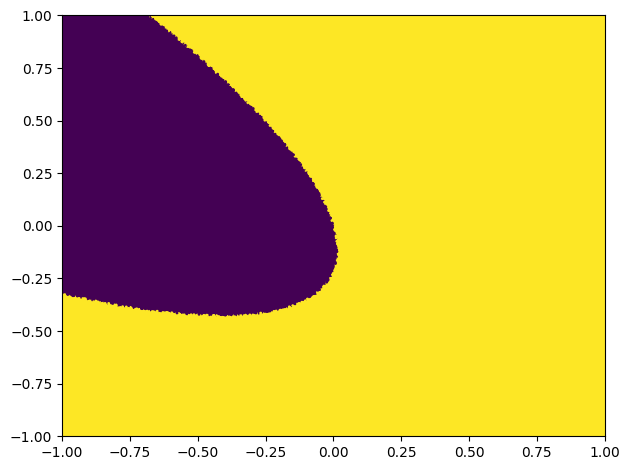

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2400,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.5133,  time_diff=0sec
m=       8,  train_acc=0.9950,  test_acc=0.7867,  time_diff=0sec
m=      16,  train_acc=0.9775,  test_acc=0.9042,  time_diff=0sec
m=      32,  train_acc=0.9750,  test_acc=0.9379,  time_diff=0sec
m=      64,  train_acc=0.9738,  test_acc=0.9579,  time_diff=0sec
m=     128,  train_acc=0.9841,  test_acc=0.9708,  time_diff=0sec
m=     256,  train_acc=0.9881,  test_acc=0.9802,  time_diff=0sec
m=     512,  train_acc=0.9929,  test_acc=0.9887,  time_diff=0sec
m=    1024,  train_acc=0.9937,  test_acc=0.9925,  time_diff=1sec
m=    2048,  train_acc=0.9957,  test_acc=0.9949,  time_diff=2sec
m=    4096,  train_acc=0.9972,  test_acc=0.9969,  time_diff=2sec
m=    8192,  train_acc=0.9971,  test_acc=0.9974,  time_diff=6sec
m=   16384,  train_acc=0.9979,  test_acc=0.9979,  time_diff=9sec
m=   32768,  train_acc=0.

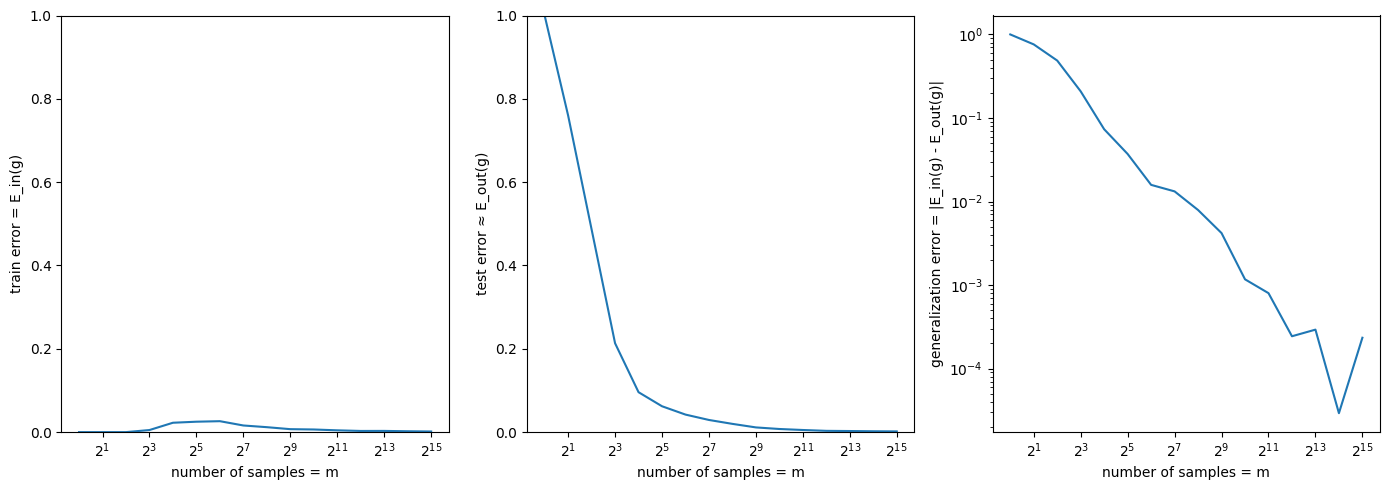

In [16]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_polynomial(p=2),
    p=2,
)

generating dataset... done


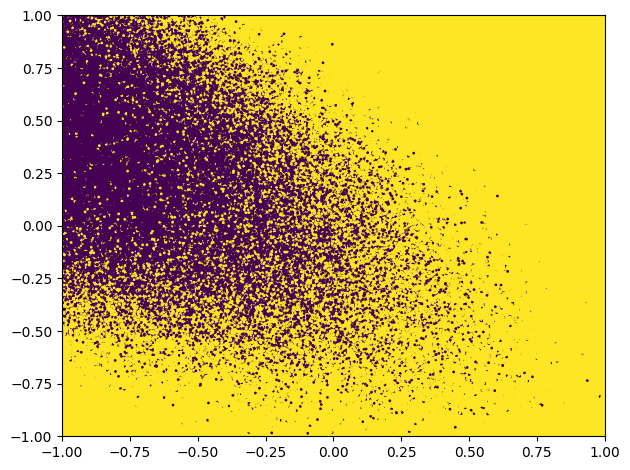

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.1933,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.4833,  time_diff=0sec
m=       8,  train_acc=0.9500,  test_acc=0.6300,  time_diff=0sec
m=      16,  train_acc=0.9175,  test_acc=0.7500,  time_diff=0sec
m=      32,  train_acc=0.8638,  test_acc=0.8254,  time_diff=0sec
m=      64,  train_acc=0.8625,  test_acc=0.8450,  time_diff=0sec
m=     128,  train_acc=0.8616,  test_acc=0.8411,  time_diff=0sec
m=     256,  train_acc=0.8548,  test_acc=0.8558,  time_diff=0sec
m=     512,  train_acc=0.8565,  test_acc=0.8546,  time_diff=0sec
m=    1024,  train_acc=0.8623,  test_acc=0.8680,  time_diff=1sec
m=    2048,  train_acc=0.8647,  test_acc=0.8742,  time_diff=1sec
m=    4096,  train_acc=0.8674,  test_acc=0.8751,  time_diff=2sec
m=    8192,  train_acc=0.8671,  test_acc=0.8770,  time_diff=4sec
m=   16384,  train_acc=0.8680,  test_acc=0.8779,  time_diff=9sec
m=   32768,  train_acc=0.

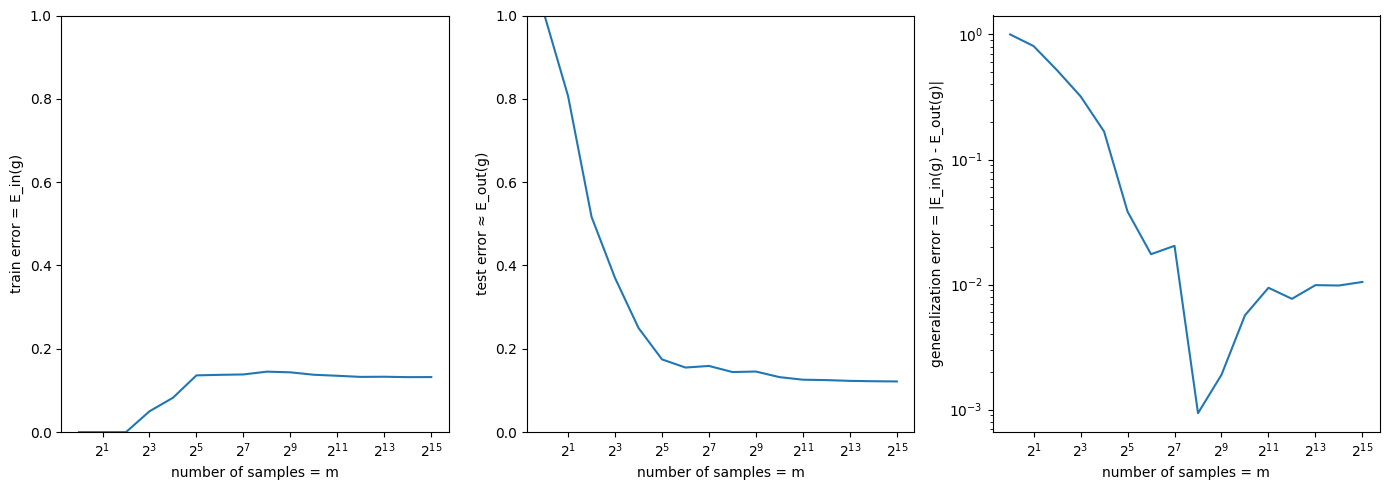

In [17]:
calculate_err_vs_m(
    d=2,
    sigma=0.2,
    f=f_polynomial(p=2),
    p=2,
)

### Definitions

We briefly introduce some common definitions that are not found in the textbook and we have not directly discussed in class.
These definitions will help us more succinctly state the following questions.
Another purpose of these definitions is to give you practice working with new definitions that you haven't seen explained before.
Data mining literature very frequently introduces new definitions that will be closely related,
but subtly different to definitions you've used before.

We call the "approximation error" of a hypothesis class to be the true error of the best possible model in the hypothesis class.
That is, the approximation error is
$$
E_{approx}(\mathcal{H}) = \text{argmin}_{h\in \mathcal H} E_{out}(h).
$$
Notice that the approximation error depends both on the hypothesis class chosen for learning, but also on the data distribution (since $E_{out}$ depends on the data distribution).
It does not, however, depend on the training data.

We call a hypothesis class "realizable" when the approximation error is 0.
That is, there exists some $h \in \mathcal H$ with $E_{out}(h) = 0$.
Notice that this definition is independent of the training data and the training algorithm.

### Question 3.1

*The three cells above plot the accuracy of the polynomial kernel in three situations:
when the model is not realizable because the degree of the polynomial is too small,
when the model is realizable,
and when the model is not realizable because of randomness in the labeling process.*

*Write 1-2 sentences about the differences you observe in each of these cases and how they relate to VC theory.*

In the first case, we see that the model is unable to achieve $E_{out} = 0$, and VC theory suggests that this is the case because the model is underfitted to the data and lacks sufficient complexity. In the second case, increasing the models complexity by adding the polynomial kernel gives the model with the optimal VC dimension since we achieve $E_{out} = 0$ with a sufficient amount data. In the final case, the noise in the data makes it so that no matter how much data we add, we will never be able to find a function that perfectly classifies all data points.



generating dataset... done


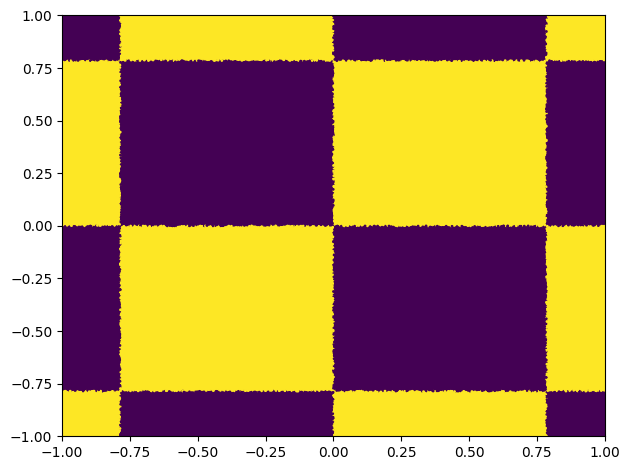

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2200,  time_diff=0sec
m=       4,  train_acc=0.9900,  test_acc=0.5067,  time_diff=0sec
m=       8,  train_acc=1.0000,  test_acc=0.5000,  time_diff=0sec
m=      16,  train_acc=0.9600,  test_acc=0.5508,  time_diff=0sec
m=      32,  train_acc=0.8675,  test_acc=0.6408,  time_diff=1sec
m=      64,  train_acc=0.8869,  test_acc=0.7252,  time_diff=3sec
m=     128,  train_acc=0.8666,  test_acc=0.7752,  time_diff=7sec
m=     256,  train_acc=0.9303,  test_acc=0.8696,  time_diff=13sec
m=     512,  train_acc=0.9523,  test_acc=0.9288,  time_diff=24sec
m=    1024,  train_acc=0.9630,  test_acc=0.9518,  time_diff=30sec
m=    2048,  train_acc=0.9715,  test_acc=0.9644,  time_diff=40sec
m=    4096,  train_acc=0.9737,  test_acc=0.9722,  time_diff=58sec
m=    8192,  train_acc=0.9815,  test_acc=0.9820,  time_diff=94sec
m=   16384,  train_acc=0.9819,  test_acc=0.9826,  time_diff=161sec
m=   32768,  trai

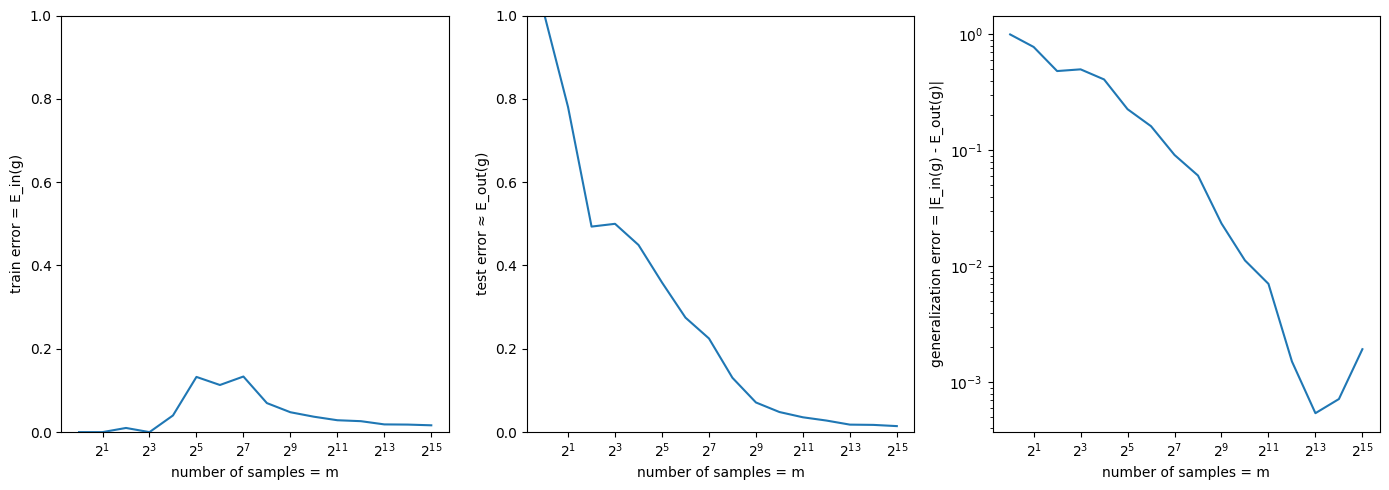

In [24]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_checkers(),
    p=22,
)

### Question 3.2

*The dataset above is generated from the checkboard embedding instead of the polynomial embedding.
This implies that the polynomial embedding model is non-realizable for this problem.
Therefore, even when there is no randomness in the labeling process,
the model still cannot achieve 0 approximation error (i.e. $E_{out}(h)>0$ for all $h \in E_{out}(h)$.*

*Increasing the polynomial degree $p$ reduces the approximation error.
Try each value of $p$ starting at 1 until you reach an approximation error<1%.
What is that value of $p$?*

The best value of $p$ that I found was $p = 22$, which had $E_{out} = 0.0144$. After that, $E_out$ started increasing again.

generating dataset... done


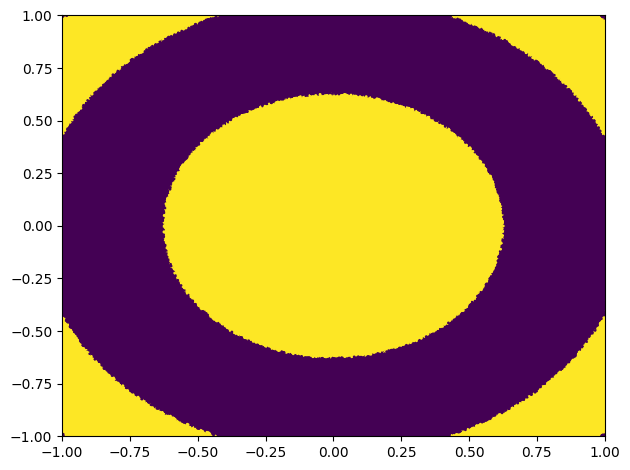

m=       1,  train_acc=1.0000,  test_acc=0.0000,  time_diff=0sec
m=       2,  train_acc=1.0000,  test_acc=0.2533,  time_diff=0sec
m=       4,  train_acc=1.0000,  test_acc=0.5167,  time_diff=0sec
m=       8,  train_acc=0.9750,  test_acc=0.5817,  time_diff=0sec
m=      16,  train_acc=0.9475,  test_acc=0.7192,  time_diff=0sec
m=      32,  train_acc=0.9363,  test_acc=0.7767,  time_diff=0sec
m=      64,  train_acc=0.9669,  test_acc=0.8690,  time_diff=0sec
m=     128,  train_acc=0.9625,  test_acc=0.9284,  time_diff=0sec
m=     256,  train_acc=0.9855,  test_acc=0.9635,  time_diff=1sec
m=     512,  train_acc=0.9860,  test_acc=0.9755,  time_diff=3sec
m=    1024,  train_acc=0.9885,  test_acc=0.9834,  time_diff=5sec
m=    2048,  train_acc=0.9889,  test_acc=0.9885,  time_diff=6sec
m=    4096,  train_acc=0.9890,  test_acc=0.9910,  time_diff=10sec
m=    8192,  train_acc=0.9894,  test_acc=0.9923,  time_diff=14sec
m=   16384,  train_acc=0.9902,  test_acc=0.9938,  time_diff=22sec
m=   32768,  train_acc

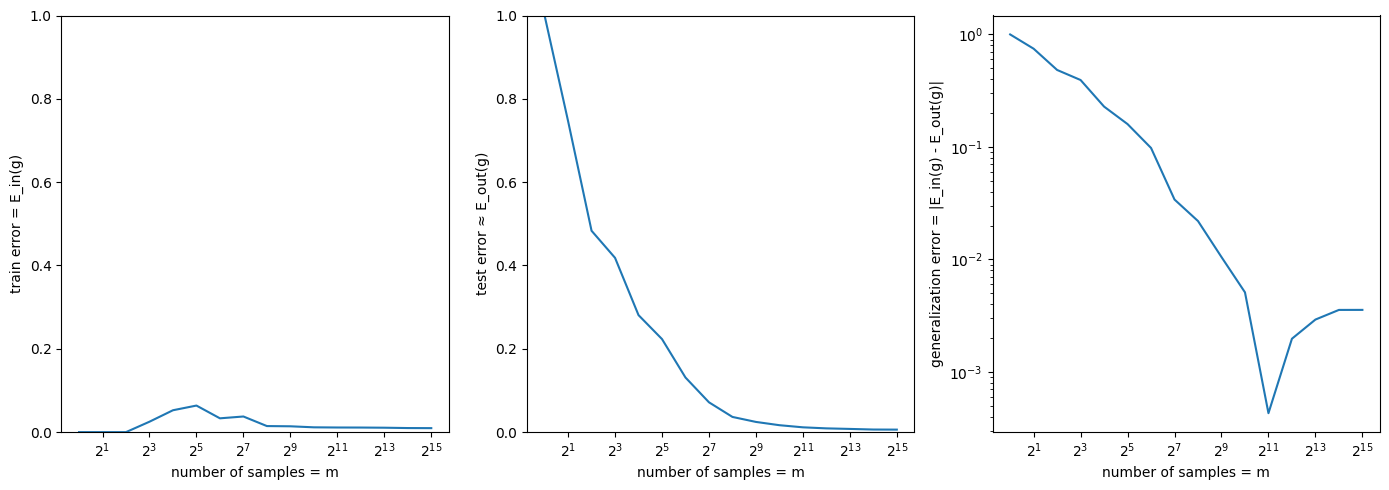

In [25]:
calculate_err_vs_m(
    d=2,
    sigma=0,
    f=f_circles(),
    p=9,
)

### Question 3.3

*The dataset above is also not realizable, but in a different way than in question 3.2.
Once again, your task is to find the exact $p$ value that will achieve an approximation error<0.01%.*

The value that minimized $E_out$ was $p = 9$, which achieved an $E_out$ of $E_out = 0.0060$. After that, $E_out$ started increasing again.

## Part 4: plotting the error as a function of the sample size $d$

In [26]:
def calculate_err_vs_d(m, sigma, f, p, max_dim_exponent, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of the number of sample training points.
    '''
    m_buffer = 3
    assert(2**max_dim_exponent<max_d)

    # these lists store the computer training and test errors
    test_errs = []
    train_errs = []

    # This is the list of all sample sizes we will train models on and generate train/test errors;
    # by adjusting the range(), you can adjust the x-axis in the plots below.
    ds = [ 2**i for i in range(0,max_dim_exponent) ]

    for d in ds:

        # In order to "smooth" the plots, we will repeat each experiment multiple times
        # as deterimed by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []


        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base,seed_base+num_trials):

            # generate a training set of size m
            # from the same distribution as our test set;
            # notice that we must explicitly set a unique seed for each trial so that
            # each iteration is actually running on a different training set
            S_train = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed)
            S_test = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed-1)

            try:
                # train a linear model;
                # notice that the training currently uses the LogisticRegression model;
                # all of the results will be essentially the same using the other linear models as well
                # since they all use the same hypothesis class
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                h_S = sklearn.linear_model.LogisticRegression(solver='liblinear',C=1e1)
                #h_S = sklearn.linear_model.Perceptron()
                #h_S = sklearn.linear_model.SGDClassifier()
                #h_S = sklearn.linear_model.PassiveAggressiveClassifier()
                #h_S = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                #h_S = sklearn.svm.LinearSVC()
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X,Y)

                # calculate the test accuracy
                X, Y = S_test
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                test_acc = h_S.score(X, Y)

            # ValueError raised when there's not enough data to perform classification;
            # in this case, we get perfect training accuracy, but perfectly wrong test accuracy
            except ValueError:
                train_acc = 1
                test_acc = 0

            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()

        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)

        # print a debugging statement for each iteration
        print('d=%8d,  train_acc=%0.4f,  test_acc=%0.4f,  time_diff=%dsec'%(
            d,
            train_acc,
            test_acc,
            time_end-time_start
        ))

        # convert the accuracies into errors and store them
        train_errs.append(1-train_acc)
        test_errs.append(1-test_acc)

    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.set_xscale('log',base=2)
    #ax1.set_yscale('log')
    ax1.set(
        xlabel='number of dimensions = d',
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ds,train_errs)

    ax2.set_xscale('log',base=2)
    #ax2.set_yscale('log')
    ax2.set(
        xlabel='number of dimensions = d',
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ds,test_errs)

    ax3.set_xscale('log',base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='number of dimensions = d',
        ylabel='generalization error = |E_in(g) - E_out(g)|',

    )
    ax3.plot(ds,np.abs(np.array(test_errs)-np.array(train_errs)))

    plt.tight_layout()
    plt.show()


d=       1,  train_acc=0.9611,  test_acc=0.9599,  time_diff=0sec
d=       2,  train_acc=0.9606,  test_acc=0.9586,  time_diff=0sec
d=       4,  train_acc=0.9743,  test_acc=0.9696,  time_diff=0sec
d=       8,  train_acc=0.9799,  test_acc=0.9729,  time_diff=0sec
d=      16,  train_acc=0.9846,  test_acc=0.9730,  time_diff=0sec
d=      32,  train_acc=0.9925,  test_acc=0.9646,  time_diff=0sec
d=      64,  train_acc=0.9993,  test_acc=0.9422,  time_diff=1sec
d=     128,  train_acc=1.0000,  test_acc=0.8993,  time_diff=2sec
d=     256,  train_acc=1.0000,  test_acc=0.8215,  time_diff=4sec
d=     512,  train_acc=1.0000,  test_acc=0.7395,  time_diff=8sec
d=    1024,  train_acc=1.0000,  test_acc=0.6807,  time_diff=17sec
d=    2048,  train_acc=1.0000,  test_acc=0.6330,  time_diff=31sec


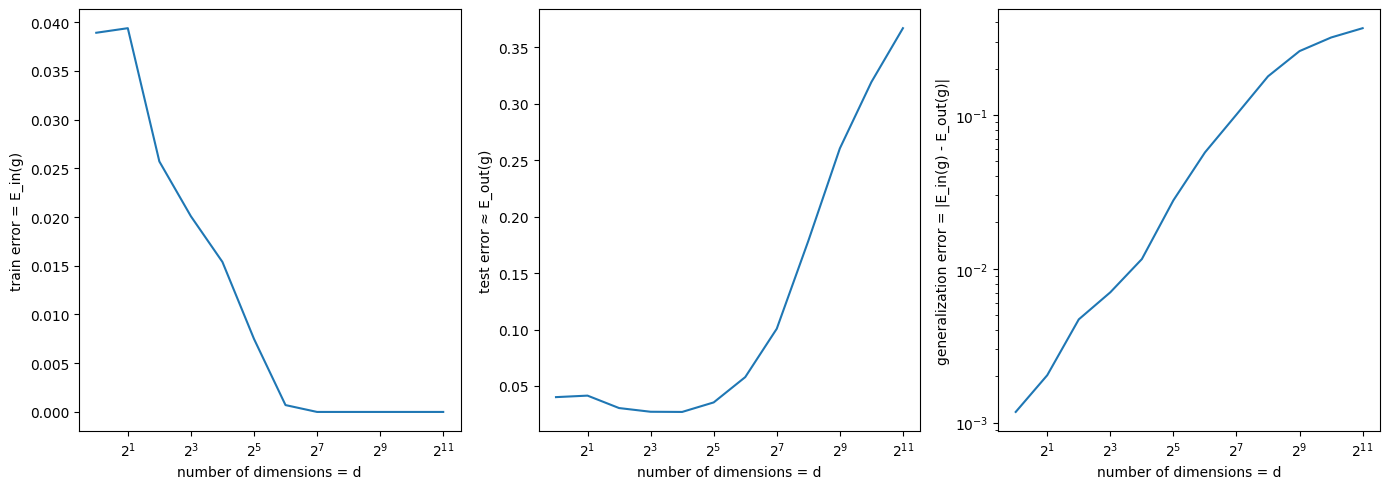

In [27]:
calculate_err_vs_d(
    m = 512,
    sigma = 0.1,
    f = f_polynomial(p=1),
    p = 1,
    max_dim_exponent=12,
)

### Question 4.1

*How does increasing the dimension $d$ of the input space affect the errors of the model?
How does VC theory predict this behavior?*

We can see that increasing $d$ decreases the training errors, increases the generalization errors, and starts out decreasing the test error slightly until reaching a minimum, and then quickly increases as $d$ continues to increase. VC theory predicts that as the VC dimension (which measures the complexity of the model) increases, the model can fit the in-sample error better, but risks overfitting after a certain point. Since $d_{VC} = d + 1$ for the perceptron hypothesis class, VC theory predicts the behavior seen here.

d=       1,  train_acc=0.9340,  test_acc=0.9322,  time_diff=0sec
d=       2,  train_acc=0.8240,  test_acc=0.8207,  time_diff=0sec
d=       4,  train_acc=0.8854,  test_acc=0.8795,  time_diff=0sec
d=       8,  train_acc=0.7644,  test_acc=0.7512,  time_diff=1sec
d=      16,  train_acc=0.7397,  test_acc=0.7124,  time_diff=4sec
d=      32,  train_acc=0.6839,  test_acc=0.6278,  time_diff=14sec
d=      64,  train_acc=0.6754,  test_acc=0.5610,  time_diff=61sec
d=     128,  train_acc=0.7355,  test_acc=0.5223,  time_diff=392sec


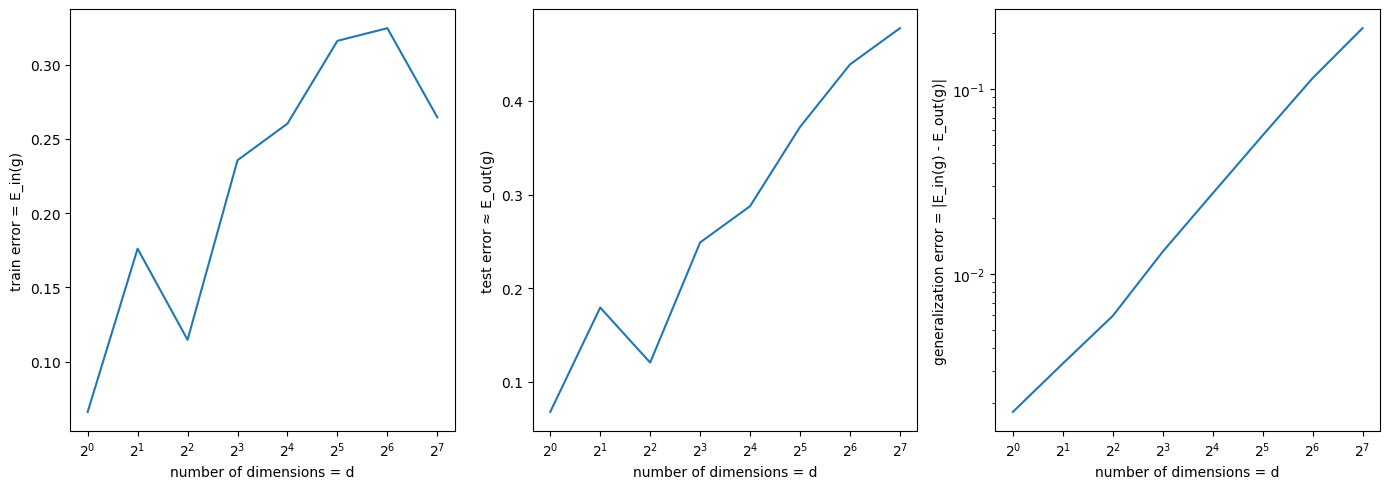

In [47]:
calculate_err_vs_d(
    m = 512,
    sigma = 0.1,
    f = f_polynomial(p=2),
    p = 1,
    max_dim_exponent=8
)

### Question 4.2

*The plot above is generated using almost the same formula as the plot for 4.1.
The exception is that the $f$ function is more complicated (polynomial degree 2 instead of degree 1).
What effect does this have on the the errors?*

We can see that now $E_in$ now increases as $d$ increases, and generalization error and test error are also still increasing. This is somewhat counterintuitive, as we would expect a more complex hypothesis class to fit the training data better or at least equally well. However, this increase in training error could be due to the model becoming unstable or more sensitive to noise with higher-dimensional data, as it’s trying to fit a more complex function (polynomial degree 2).

## Part 5: plotting the error as a function of the polynomial degree

### Question 5.1

The goal of this question is to demonstrate that large degree polynomial embeddings overfit.
This will require writing a new function `calculate_err_vs_p` that is based off of `calculate_err_vs_m` and `calculate_err_vs_d`.
Plot the train, test, and generalization errors as a function of `p`.
You should find that "small" and "large" values both generate large test errors,
and "medium" values of `p` generate small test errors.

I recommend using values of `m = 32`, `d = 8`, `sigma = 0.0`, and `f = f_polynomial(p=2)`.
Adjust the value of the `p` variable starting at `1` and going large enough to see the pattern of overfitting.

In [54]:
def calculate_err_vs_p(m, sigma, f, d, max_p, num_trials=default_num_trials):
    '''
    Plots the sample/true/generalization error for the halfspace with polynomial kernel model
    as a function of the number of sample training points.
    '''
    m_buffer = 3

    # these lists store the computer training and test errors
    test_errs = []
    train_errs = []

    # This is the list of all sample sizes we will train models on and generate train/test errors;
    # by adjusting the range(), you can adjust the x-axis in the plots below.
    ps = [ i for i in range(1,max_p) ]

    for p in ps:

        # In order to "smooth" the plots, we will repeat each experiment multiple times
        # as deterimed by the num_trials parameter.
        # These lists store the raw results from each trial.
        trials_test_accs = []
        trials_train_accs = []


        # loop over each trial
        seed_base = 10
        time_start = time.time()
        for seed in range(seed_base,seed_base+num_trials):

            # generate a training set of size m
            # from the same distribution as our test set;
            # notice that we must explicitly set a unique seed for each trial so that
            # each iteration is actually running on a different training set
            S_train = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed)
            S_test = generate_dataset(m=m,d=d,f=f,sigma=sigma,seed=seed-1)

            try:
                # train a linear model;
                # notice that the training currently uses the LogisticRegression model;
                # all of the results will be essentially the same using the other linear models as well
                # since they all use the same hypothesis class
                X, Y = S_train
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                h_S = sklearn.linear_model.LogisticRegression(solver='liblinear',C=1e1)
                #h_S = sklearn.linear_model.Perceptron()
                #h_S = sklearn.linear_model.SGDClassifier()
                #h_S = sklearn.linear_model.PassiveAggressiveClassifier()
                #h_S = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
                #h_S = sklearn.svm.LinearSVC()
                h_S.fit(X, Y)

                # calculate the training accuracy
                train_acc = h_S.score(X,Y)

                # calculate the test accuracy
                X, Y = S_test
                X = np.apply_along_axis(lambda x: polynomial_kernel_embedding(x,p),1,X)
                test_acc = h_S.score(X, Y)

            # ValueError raised when there's not enough data to perform classification;
            # in this case, we get perfect training accuracy, but perfectly wrong test accuracy
            except ValueError:
                train_acc = 1
                test_acc = 0

            trials_test_accs.append(test_acc)
            trials_train_accs.append(train_acc)
        time_end = time.time()

        # compute the average of our trials
        train_acc = np.mean(trials_train_accs)
        test_acc = np.mean(trials_test_accs)

        # print a debugging statement for each iteration
        print('p=%8d,  train_acc=%0.4f,  test_acc=%0.4f,  time_diff=%dsec'%(
            p,
            train_acc,
            test_acc,
            time_end-time_start
        ))

        # convert the accuracies into errors and store them
        train_errs.append(1-train_acc)
        test_errs.append(1-test_acc)

    # plot the errors
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.set_xscale('log',base=2)
    #ax1.set_yscale('log')
    ax1.set(
        xlabel='polynomial order = p',
        ylabel='train error = E_in(g)',
    )
    ax1.plot(ps,train_errs)

    # ax2.set_xscale('log',base=2)
    #ax2.set_yscale('log')
    ax2.set(
        xlabel='polynomial order = p',
        ylabel='test error ≈ E_out(g)',
    )
    ax2.plot(ps,test_errs)

    # ax3.set_xscale('log',base=2)
    ax3.set_yscale('log')
    ax3.set(
        xlabel='polynomial order = p',
        ylabel='generalization error = |E_in(g) - E_out(g)|',

    )
    ax3.plot(ps,np.abs(np.array(test_errs)-np.array(train_errs)))

    plt.tight_layout()
    plt.show()


p=       1,  train_acc=0.8538,  test_acc=0.6887,  time_diff=0sec
p=       2,  train_acc=1.0000,  test_acc=0.7412,  time_diff=0sec
p=       3,  train_acc=1.0000,  test_acc=0.7438,  time_diff=0sec
p=       4,  train_acc=1.0000,  test_acc=0.7188,  time_diff=0sec
p=       5,  train_acc=1.0000,  test_acc=0.7188,  time_diff=2sec
p=       6,  train_acc=1.0000,  test_acc=0.7150,  time_diff=5sec
p=       7,  train_acc=1.0000,  test_acc=0.7013,  time_diff=14sec
p=       8,  train_acc=1.0000,  test_acc=0.7013,  time_diff=30sec
p=       9,  train_acc=1.0000,  test_acc=0.6987,  time_diff=57sec


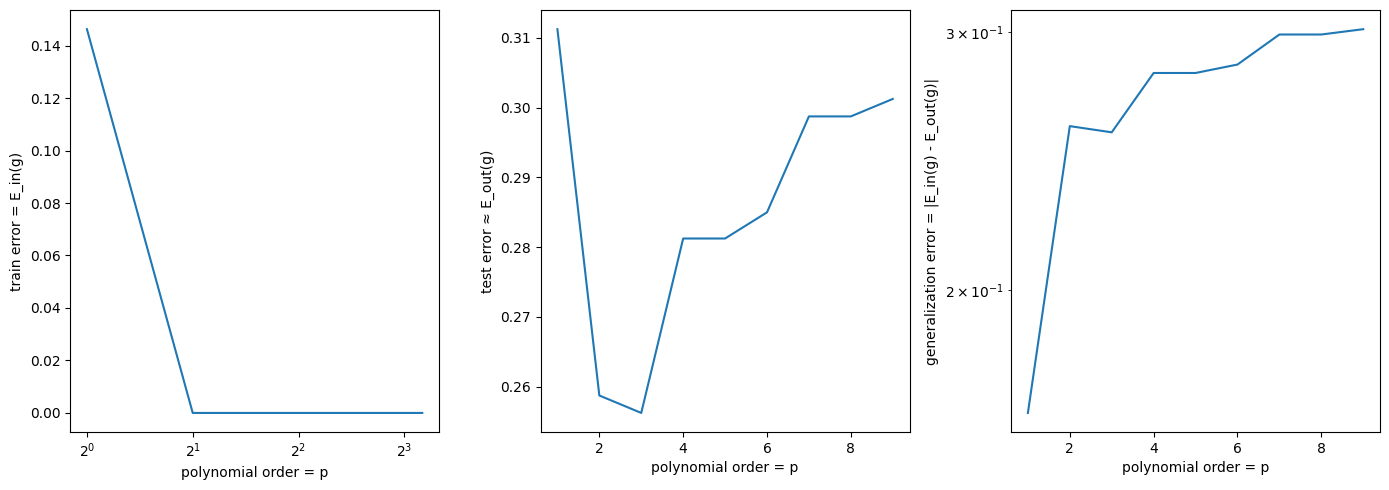

In [55]:
calculate_err_vs_p(
    m = 32,
    sigma = 0.0,
    f = f_polynomial(p=2),
    d = 8,
    max_p=10
)

We can see that for this dataset, a polynomial order of $p = 3$ has the best out of sample performance. Since increasing p results in increasing the VC dimension, the in-sample, out-of-sample, and generalization errors all follow the trend we would expect based on VC theory, with the training error decreasing, the generalization error increasing, and the test error decreasing until a minimum and then increasing again.